# Predicting Probability of Fast Growth 

**Author:** Elene Zuroshvili & Luciana Razuri Solari

**Dataset:** `bisnode_firms_clean_elene.csv`  

**Goal:** Predict the probability that a firm is classified as **fast-growth** using financial + firm characteristics.

This cell is a markdown header for the 'Setup' section of the notebook.

## 1. Setup

This code cell is for importing all the necessary Python libraries for data manipulation, analysis, modeling, and visualization. It includes pandas, numpy, statsmodels, scikit-learn, and plotting libraries like seaborn and matplotlib. It also suppresses warnings to keep the output clean.

In [6]:
import os
import pandas as pd
import numpy as np
import sys
import patsy
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import sklearn.metrics as metrics
from sklearn.metrics import brier_score_loss, roc_curve, auc, confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')


This markdown cell introduces a section for helper functions, which are designed to standardize evaluation outputs and plots throughout the notebook.

### Helper functions
These functions standardize evaluation outputs and plots used throughout the notebook.

This cell defines a series of helper functions that will be used throughout the notebook for tasks such as calculating regression metrics (`regression_results`), creating a coefficient matrix (`coef_matrix`), summarizing cross-validation results (`cv_summary`), applying the sigmoid function (`sigmoid_array`), generating predictions for a cross-validation fold (`generate_fold_prediction`), and creating various plots like loss curves (`create_loss_plot`) and ROC curves (`create_roc_plot`, `create_roc_plot_with_optimal`).

In [7]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print("explained_variance: ", round(explained_variance, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))


def coef_matrix(X, model):

    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1
    )
    coef_matrix.columns = ["variable", "coefficient"]
    coef_matrix = coef_matrix.append(
        {"variable": "Intercept", "coefficient": model.intercept_},
        ignore_index=True,
    )
    return coef_matrix


def cv_summary(lambdas, C_values, model):
    d = {
        "lambdas": lambdas,
        "C_values": C_values,
        "mean_cv_score": model.scores_[1].mean(axis=0),
    }
    return pd.DataFrame(data=d)


def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))


def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold, param_index, :]
    return sigmoid_array(
        np.dot(X, np.transpose(fold_coef)[:-1]) + np.transpose(fold_coef)[-1]
    )


def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy["loss"] = (
        all_coords_copy.false_pos * FP + all_coords_copy.false_neg * FN
    ) / all_coords_copy.n

    t = optimal_threshold
    l = curr_exp_loss

    # Plot loss curve
    sns.lineplot(x=all_coords_copy["thresholds"], y=all_coords_copy["loss"])

    # Vertical line for optimal threshold
    plt.axvline(x=t, linestyle="--")

    # Annotations
    plt.text(
        t - 0.03,
        all_coords_copy["loss"].max() - 0.7,
        f"Best threshold: {round(t, 2)}",
        color=da.color[1],
        rotation=90,
        fontsize=8,
    )
    plt.text(t + 0.06, l, f"{round(l, 2)}", fontsize=8)

    # Labels and limits
    plt.xlabel("Thresholds")
    plt.ylabel("Expected loss")
    plt.xlim(-0.01, 1.01)
    plt.xticks(np.arange(0, 1.1, 0.1))

    # Style
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.show()


def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # Plot ROC curve
    sns.lineplot(x=fpr, y=tpr, linewidth=1)

    # Fill area under curve
    plt.fill_between(fpr, tpr, alpha=0.3, color="mediumaquamarine")

    # Diagonal reference line
    plt.plot([0, 1], [0, 1], linestyle="dotted", color="black", linewidth=0.9)

    # Labels and limits
    plt.xlabel("False Positive Rate (1-Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))

    # Style
    sns.despine()
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.show()


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy["sp"] = 1 - all_coords_copy.true_neg / all_coords_copy.neg
    all_coords_copy["se"] = all_coords_copy.true_pos / all_coords_copy.pos

    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    # Plot ROC curve
    sns.lineplot(x=all_coords_copy["sp"], y=all_coords_copy["se"])

    # Highlight optimal threshold point
    plt.scatter(sp, se, color="black", s=10)
    plt.text(sp, se + 0.03, f"{round(sp, 2)}, {round(se, 2)}", fontsize=10, ha="center")

    # Fill area under curve
    plt.fill_between(
        all_coords_copy["sp"],
        all_coords_copy["se"],
        alpha=0.3,
        color="mediumaquamarine",
    )

    # Diagonal reference line
    plt.plot([0, 1], [0, 1], linestyle="dotted", color="black", linewidth=0.9)

    # Labels and limits
    plt.xlabel("False Positive Rate (1-Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.xlim(0, 1.01)
    plt.ylim(0, 1.01)
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))

    # Style
    sns.despine()
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.show()

This cell is a markdown header for the 'Load data' section of the notebook.

## 2. Load data

This code cell loads the dataset `bisnode_firms_clean_elene.csv` into a pandas DataFrame. It then prints the shape of the data, the first few rows, and the distribution of the target variable 'fast_growth'.

In [8]:
# DATA IMPORT - FROM FILE
data = pd.read_csv('../data/bisnode_firms_clean_50%.csv')
print(data.shape)
print(data.head(3))
print(data['fast_growth'].value_counts(dropna=False).to_frame('count').assign(share=lambda d: d['count']/d['count'].sum()))

(19036, 120)
   year    comp_id       begin         end         amort    curr_assets  \
0  2012  1001541.0  2012-01-01  2012-12-31    481.481476    9629.629883   
1  2012  1002029.0  2012-01-01  2012-12-31  14929.629883  203885.187500   
2  2012  1003200.0  2012-01-01  2012-12-31     25.925926      22.222221   

       curr_liab  extra_exp  extra_inc  extra_profit_loss  ...  \
0    1303.703735        0.0        0.0                0.0  ...   
1  120444.453125        0.0        0.0                0.0  ...   
2   10996.295898        0.0        0.0                0.0  ...   

   flag_miss_ceo_age  ceo_young  labor_avg_mod  flag_miss_labor_avg  \
0                  0          1       0.621691                    1   
1                  0          1       0.458333                    0   
2                  1          0       0.621691                    1   

        default_f  sales_mil_log_sq  flag_low_d1_sales_mil_log  \
0     fast_growth         45.190017                          1   
1  n

This markdown cell explains the feature engineering and design choices. It mentions the use of one-hot encoding for categorical variables and lists the different groups of variables that will be used in the models.

## 3. Feature engineering and design choices

For categorical variables, we one-hot encode and drop one reference level to avoid perfect multicollinearity (the "dummy variable trap").

variables in use:

(i) main firm variables

(ii) further financial variables

(iii) flag variables

(iv) growth variables 

(v) human capital related variables

(vi) firms history related variables

(vii) interactions for logit and lasso


This cell defines several lists of variable names that will be used to build different models. These lists categorize the features into raw financial variables (`rawvars`), data quality variables (`qualityvars`), engineered financial ratios (`engvar`, `engvar2`), flag variables (`engvar3`), growth variables (`d1`), human resource variables (`hr`), firm-level variables (`firm`), and interaction terms (`interactions1`, `interactions2`).

In [9]:
rawvars = ["curr_assets", "curr_liab", "extra_exp", "extra_inc", "extra_profit_loss", "fixed_assets",
              "inc_bef_tax", "intang_assets", "inventories", "liq_assets", "material_exp", "personnel_exp",
              "profit_loss_year", "sales", "share_eq", "subscribed_cap"]
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = ["total_assets_bs", "fixed_assets_bs", "liq_assets_bs", "curr_assets_bs",
            "share_eq_bs", "subscribed_cap_bs", "intang_assets_bs", "extra_exp_pl",
            "extra_inc_pl", "extra_profit_loss_pl", "inc_bef_tax_pl", "inventories_pl",
            "material_exp_pl", "profit_loss_year_pl", "personnel_exp_pl"]
engvar2 = ["extra_profit_loss_pl_quad", "inc_bef_tax_pl_quad",
             "profit_loss_year_pl_quad", "share_eq_bs_quad"]
engvar3 = []
for col in data.columns:
    if col.endswith('flag_low') or col.endswith('flag_high') or col.endswith('flag_error') or col.endswith('flag_zero'):
        engvar3.append(col)


d1 =  ["d1_sales_mil_log_mod", "d1_sales_mil_log_mod_sq",
         "flag_low_d1_sales_mil_log", "flag_high_d1_sales_mil_log"]
hr = ["female", "ceo_age", "flag_high_ceo_age", "flag_low_ceo_age",
        "flag_miss_ceo_age", "ceo_count", "labor_avg_mod",
        "flag_miss_labor_avg", "foreign_management"]
firm = ["age", "age2", "new", "C(ind2_cat)", "C(m_region_loc)", "C(urban_m)"]
interactions1 = [
    "C(ind2_cat)*age",
    "C(ind2_cat)*age2",
    "C(ind2_cat)*d1_sales_mil_log_mod",
    "C(ind2_cat)*sales_mil_log",
    "C(ind2_cat)*ceo_age",
    "C(ind2_cat)*foreign_management",
    "C(ind2_cat)*female",
    "C(ind2_cat)*C(urban_m)",
    "C(ind2_cat)*labor_avg_mod",
]
interactions2 = [
    "sales_mil_log*age",
    "sales_mil_log*female",
    "sales_mil_log*profit_loss_year_pl",
    "sales_mil_log*foreign_management",
]

This cell is a markdown header for the 'Model Setups' section, outlining the different types of models that will be built: five logistic regression models, a logistic regression with LASSO regularization, and a Random Forest model.

## 4. Model Setups

(i) 5 logit models

(ii) logit + lasso

(iii) Cart and rf


This cell defines the feature sets for the five logistic regression models (M1 to M5), the variables for the LASSO model (`logit_lasso_vars`), and the variables for the Random Forest model (`rfvars`).

In [10]:
M1 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "d1_sales_mil_log_mod",
    "profit_loss_year_pl",
    "C(ind2_cat)",
]
M2 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "d1_sales_mil_log_mod",
    "profit_loss_year_pl",
    "fixed_assets_bs",
    "share_eq_bs",
    "curr_liab_bs ",
    "curr_liab_bs_flag_high ",
    "curr_liab_bs_flag_error",
    "age",
    "foreign_management",
    "C(ind2_cat)",
]
M3 = ["sales_mil_log", "sales_mil_log_sq"] + firm + engvar + d1
M4 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + qualityvars
)
M5 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + qualityvars
    + interactions1
    + interactions2
)

logit_lasso_vars = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + firm
    + qualityvars
    + interactions1
    + interactions2
)

rfvars = ["sales_mil", "d1_sales_mil_log"] + rawvars + hr + firm + qualityvars

## 4. Train / holdout split

- We keep a **holdout set (20%)** for final evaluation.
- Cross-validation is done **only on the training set**.


This code cell splits the data into training and holdout sets using an 80/20 split. The `random_state` is set for reproducibility.

In [11]:
data_train, data_holdout = train_test_split(data, train_size=0.8, random_state=42)

This cell prints the proportion of the target variable 'fast_growth' in the total dataset, the training set, and the holdout set to ensure that the split is stratified.

In [12]:
print('Total')
print(data['fast_growth'].value_counts(normalize=True))
print('Train')
print(data_train['fast_growth'].value_counts(normalize=True))
print('Holdout')
print(data_holdout['fast_growth'].value_counts(normalize=True))

Total
fast_growth
0    0.789714
1    0.210286
Name: proportion, dtype: float64
Train
fast_growth
0    0.79032
1    0.20968
Name: proportion, dtype: float64
Holdout
fast_growth
0    0.78729
1    0.21271
Name: proportion, dtype: float64


This cell is a markdown header for the 'Baseline models (interpretable)' section. It introduces the first set of simple models to be trained: linear regression and logistic regression, using three different feature sets (X1, X2, and X4).

## 5. Baseline models (interpretable)

We start with simple models:
- Linear regression (for reference only)
- Logistic regression (probability model)

Baseline feature sets:
- **X1**: minimal core predictors + industry dummies  
- **X2**: X1 + selected additional financial/firm predictors  
- **X4**: broader set of engineered predictors, but **no interactions**


This cell sets up and runs a 5-fold cross-validation for five different logistic regression models (M1 to M5). It uses `LogisticRegressionCV` to find the best model and calculates the RMSE for each fold. The results are stored in a DataFrame.

In [13]:
k = KFold(n_splits=5, shuffle=True, random_state=42)
logit_model_vars = [M1, M2, M3, M4, M5]
C_value_logit = [1e20]
logit_models = dict()
CV_RMSE_folds = dict()

for i, model_vars in enumerate(logit_model_vars):

    model_equation = "fast_growth~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_brier = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="neg_brier_score",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_brier.fit(X_train, y_train)

    # Calculate RMSE on test for each fold
    CV_RMSE_folds["M" + str(i + 1)] = np.sqrt(
        -1 * logit_models["M" + str(i + 1)].scores_[1].ravel()
    )
CV_RMSE_folds_df = pd.DataFrame(CV_RMSE_folds)

This cell displays the DataFrame containing the cross-validated RMSE for each of the five logistic regression models.

In [14]:
CV_RMSE_folds_df

,M1,M2,M3,M4,M5
0,0.401409,0.396371,0.394639,0.392242,0.393152
1,0.407037,0.401621,0.399003,0.397369,0.396236
2,0.402871,0.397999,0.396171,0.393800,0.394784
3,0.400988,0.397664,0.394443,0.393851,0.393618
4,0.401564,0.395826,0.394008,0.392306,0.391965


This cell is a markdown header for the 'Regularized logistic regression (LASSO)' section. It explains that LASSO is used for feature selection and to reduce overfitting in high-dimensional models like M4 and M5.

## 7. Regularized logistic regression (LASSO)

Why: X4/X5 can be high-dimensional. LASSO helps with:
- feature selection
- reducing overfitting


This cell performs LASSO-regularized logistic regression. It first standardizes the features, then uses `LogisticRegressionCV` with L1 penalty to find the best regularization strength (lambda) based on the Brier score. It also calculates the cross-validated RMSE for the best LASSO model.

In [15]:
model_equation = "fast_growth~" + "+".join(logit_lasso_vars)
y_train, X_train = patsy.dmatrices(model_equation, data_train)

normalized_logitvars = pd.DataFrame(
    StandardScaler().fit_transform(X_train),
    columns=X_train.design_info.column_names,
)

lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = normalized_logitvars.shape[0] * 4 / 5
C_values = [
    1 / (l * n_obs) for l in lambdas
]  

logLasso_brier = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=42,
)

logit_models["LASSO"] = logLasso_brier.fit(normalized_logitvars, y_train)

cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
cv_summary_lasso["mean_cv_score"] = np.sqrt(cv_summary_lasso["mean_cv_score"] * -1)
best_lambda_i = cv_summary_lasso["mean_cv_score"].idxmin()
CV_RMSE_folds["LASSO"] = np.sqrt(
    -1 * logit_models["LASSO"].scores_[1][:, best_lambda_i]
)

print(cv_summary_lasso)

    lambdas  C_values  mean_cv_score
0  0.100000  0.000821       0.419189
1  0.046416  0.001768       0.408769
2  0.021544  0.003810       0.400514
3  0.010000  0.008209       0.396767
4  0.004642  0.017685       0.394848
5  0.002154  0.038101       0.394098
6  0.001000  0.082086       0.393770
7  0.000464  0.176848       0.393915
8  0.000215  0.381008       0.394134
9  0.000100  0.820856       0.394396


This cell is a markdown header for the section on evaluating the models using AUC, Calibration Curve, Confusion Matrix, and ROC.

## 8. AUC, Calibration Curve, Confusion Matrix, ROC

This cell calculates the cross-validated AUC for each of the five logistic regression models using `LogisticRegressionCV` with 'roc_auc' scoring.

In [16]:
# logits auc
CV_AUC_folds = dict()
for i, model_vars in enumerate(logit_model_vars):

    model_equation = "fast_growth~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_auc = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="roc_auc",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_auc.fit(X_train, y_train)

    # Calculate AUC on test for each fold
    CV_AUC_folds["M" + str(i + 1)] = logit_models["M" + str(i + 1)].scores_[1].ravel()

This cell calculates the cross-validated AUC for the LASSO model, using the best lambda found previously.

In [17]:
# LASSO AUC

logLasso_auc = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="roc_auc",
    solver="liblinear",
    random_state=42,
)
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)

CV_AUC_folds["LASSO"] = logLasso_auc_fitted.scores_[1][
    :, cv_summary_lasso["mean_cv_score"].idxmin()
]

This cell creates a summary table that compares all the logistic regression models and the LASSO model based on the number of coefficients, cross-validated RMSE, and cross-validated AUC.

In [18]:
model_fits = pd.DataFrame(logit_models, index=["Model fit"]).T

summary = (
    model_fits["Model fit"]
    .apply(lambda x: x.n_features_in_)
    .to_frame(name="Number of Coefficients")
)

summary.loc["LASSO", "Number of Coefficients"] = len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

summary["CV RMSE"] = pd.DataFrame(CV_RMSE_folds).T.mean(axis=1)
summary["CV AUC"] = pd.DataFrame(CV_AUC_folds).T.mean(axis=1)
summary.round(3)

,Number of Coefficients,CV RMSE,CV AUC
M1,12,0.403,0.596
M2,19,0.398,0.636
M3,36,0.396,0.652
M4,80,0.394,0.660
M5,154,0.394,0.664
LASSO,112,0.394,0.663


This cell selects the best logistic regression model (M5), makes predictions on the holdout set, and calculates the RMSE on the holdout set.

In [19]:
from statsmodels.tools.eval_measures import rmse

best_logit = logit_models["M5"]
model_equation = "fast_growth~" + "+".join(M5)
_, X_holdout = patsy.dmatrices(model_equation, data_holdout)

data_holdout["best_logit_pred_proba"] = best_logit.predict_proba(X_holdout)[:, 1]

round(rmse(data_holdout["best_logit_pred_proba"], data_holdout["fast_growth"]), 3)

0.397

This cell generates a calibration plot for the best logistic regression model (M5) to visualize how well the predicted probabilities match the actual observed frequencies.

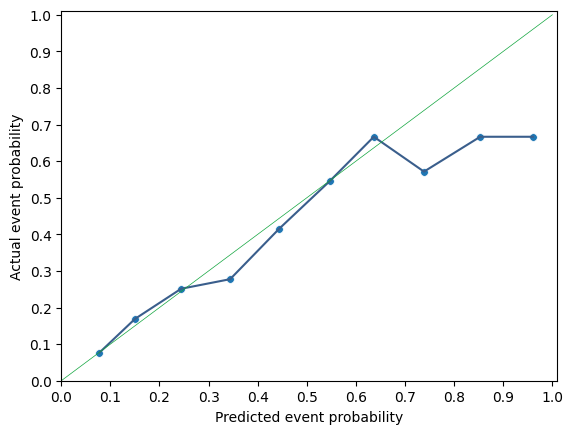

In [20]:
import py_helper_functions as da

da.create_calibration_plot(
    data_holdout,
    prob_var="best_logit_pred_proba",
    actual_var="fast_growth",
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
)

This code cell uses the best logistic regression model (M5) to predict the class labels on the holdout set and then prints the number of predicted 'no default' and 'default' cases.

In [21]:
logit_class_prediction = best_logit.predict(X_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0], " (no default): ", counts[0])
print(values[1], " (default): ", counts[1])

0.0  (no default):  3696
1.0  (default):  112


This cell generates and displays a confusion matrix for the best logistic regression model's predictions on the holdout set, using the default 0.5 threshold.

In [22]:
cm_object1 = confusion_matrix(
    data_holdout["fast_growth"], logit_class_prediction, labels=[0, 1]
)
cm1 = pd.DataFrame(
    cm_object1,
    index=["Actual no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm1

,Predicted no fast growth,Predicted fast growth
Actual no fast growth,2952,46
Actual fast growth,744,66


This cell demonstrates how to apply a different threshold (0.5 in this case, which is the same as the default) to the predicted probabilities and then generates a confusion matrix.

In [23]:
# we can apply different thresholds

# 0.5 same as before
holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < 0.5, 0, 1)
cm_object1b = confusion_matrix(
    data_holdout["fast_growth"], holdout_prediction, labels=[0, 1]
)
cm1b = pd.DataFrame(
    cm_object1b,
    index=["Actual no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm1b

,Predicted no fast growth,Predicted fast growth
Actual no fast growth,2952,46
Actual fast growth,744,66


This cell calculates and prints the mean of the predicted probabilities of default on the holdout set.

In [24]:
mean_predicted_default_prob = np.mean(data_holdout["best_logit_pred_proba"])
round(mean_predicted_default_prob, 3)

0.211

This cell uses the mean predicted probability as a threshold to classify the firms in the holdout set and then generates a confusion matrix to evaluate this new threshold.

In [25]:
holdout_prediction = np.where(
    data_holdout["best_logit_pred_proba"] < mean_predicted_default_prob, 0, 1
)
cm_object2 = confusion_matrix(
    data_holdout["fast_growth"], holdout_prediction, labels=[0, 1]
)
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actual no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm2

,Predicted no fast growth,Predicted fast growth
Actual no fast growth,1950,1048
Actual fast growth,349,461


This cell iterates through a range of thresholds to calculate the true positive rates and false positive rates, which will be used to plot the ROC curve.

In [26]:
thresholds = np.arange(0.05, 0.76, 0.05)
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < thr, 0, 1)
    cm_thr = confusion_matrix(data_holdout["fast_growth"], holdout_prediction, labels=[0, 1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp / (tp + fn))
    false_positive_rates.append(fp / (fp + tn))

This cell creates a pandas DataFrame to store the thresholds and their corresponding true positive and false positive rates.

In [27]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {
        "thresholds": thresholds,
        "true_positive_rates": true_positive_rates,
        "false_positive_rates": false_positive_rates,
    }
)

This cell creates a scatter plot of the true positive rates vs. false positive rates, with the points colored by the threshold value. This plot helps to visualize the trade-off between sensitivity and specificity at different thresholds.

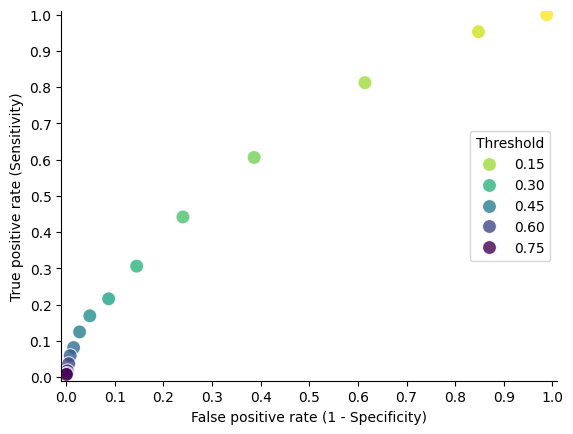

In [28]:
scatter = sns.scatterplot(
    data=tpr_fpr_for_thresholds,
    x="false_positive_rates",
    y="true_positive_rates",
    hue="thresholds",
    palette="viridis_r",
    s=100,
    alpha=0.8,
)

plt.xlabel("False positive rate (1 - Specificity)")
plt.ylabel("True positive rate (Sensitivity)")
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.xticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0, 1.01, 0.1))
plt.legend(title="Threshold", loc="center right")
sns.despine()
plt.show()

This cell generates and displays a ROC curve for the best logistic regression model's predictions on the holdout set.

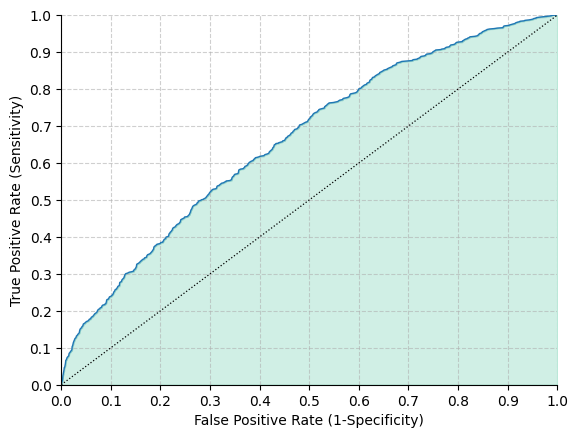

In [29]:
import warnings
warnings.filterwarnings('ignore')

# Define color palette for plots
color = ['#1f77b4', '#ff7f0e']

create_roc_plot(data_holdout["fast_growth"], data_holdout["best_logit_pred_proba"])

This cell is a markdown header for the 'Loss function' section.

## Loss function

This cell defines a custom loss function by setting the costs of false positives (FP) and false negatives (FN). It then calculates the optimal threshold for each model based on this loss function and the prevalence of the positive class. It also calculates the expected loss for each model.

In [30]:
FP = 1
FN = 10
cost = FN / FP

prevelance = y_train.sum() / len(y_train)

best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss = []

    if model_name != "LASSO":
        _, X = patsy.dmatrices("fast_growth ~" + "+".join(logit_model_vars[i]), data_train)
        X = pd.DataFrame(X)
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index, :]
        y_fold = data_train["fast_growth"].iloc[test_index]
        pred_fold = generate_fold_prediction(
            logit_models[model_name], X_fold, fold, c_index
        )
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(
            list(
                zip(
                    np.abs(
                        true_pos_rate
                        + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                    ),
                    thresholds,
                )
            ),
            key=lambda i: i[0],
            reverse=True,
        )[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(
            y_fold, threshold_prediction, labels=[0, 1]
        ).ravel()
        curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold + 1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame(
        {
            "false_pos": false_pos_rate * sum(y_fold == 0),
            "true_pos": true_pos_rate * sum(y_fold == 1),
            "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
            "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
            "pos": sum(y_fold == 1),
            "neg": sum(y_fold == 0),
            "n": len(y_fold),
            "thresholds": thresholds,
        }
    )

    fold5_all_coords[model_name] = all_coords

summary_with_lossfnc = pd.DataFrame(
    best_thresholds_cv.items(), columns=["Model", "Avg of optimal thresholds"]
)
summary_with_lossfnc["Threshold for Fold5"] = fold5_threshold.values()
summary_with_lossfnc["Avg expected loss"] = expected_loss_cv.values()
summary_with_lossfnc["Expected loss for Fold5"] = fold5_expected_loss.values()

summary_with_lossfnc

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,M1,0.123274,0.128745,0.783754,0.785550
1,M2,0.080884,0.110348,0.782309,0.772085
2,M3,0.084045,0.076372,0.782047,0.781609
3,M4,0.085527,0.069675,0.779814,0.783908
4,M5,0.076899,0.061678,0.770753,0.779310
5,LASSO,0.088896,0.076248,0.773708,0.779310


This cell generates a plot of the expected loss as a function of the threshold for the best logistic regression model (M5).

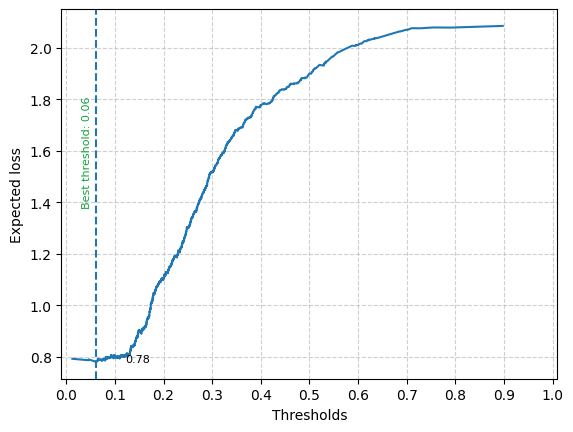

In [31]:
model_to_plot = "M5"  # select model to plot
create_loss_plot(
    fold5_all_coords[model_to_plot],
    fold5_threshold[model_to_plot],
    fold5_expected_loss[model_to_plot],
)

This cell generates a ROC curve for the best logistic regression model (M5) and highlights the point on the curve that corresponds to the optimal threshold found using the custom loss function.

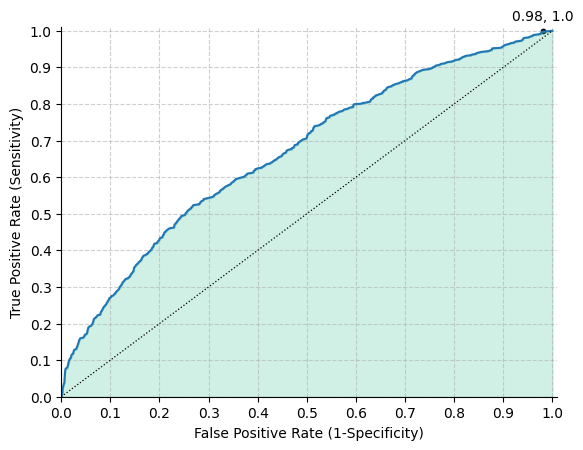

In [32]:
create_roc_plot_with_optimal(
    fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot]
)

This cell calculates the expected loss on the holdout set using the optimal threshold found for the best logistic regression model (M5).

In [33]:
best_logit_optimal_treshold = best_thresholds_cv["M5"]

# Get expected loss on holdout
holdout_treshold = np.where(
    data_holdout["best_logit_pred_proba"] < best_logit_optimal_treshold, 0, 1
)
tn, fp, fn, tp = confusion_matrix(
    data_holdout["fast_growth"], holdout_treshold, labels=[0, 1]
).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(data_holdout["fast_growth"])
round(expected_loss_holdout, 3)

0.766

This cell generates a confusion matrix for the predictions on the holdout set, using the optimal threshold determined by the custom loss function.

In [34]:
cm_object3 = confusion_matrix(data_holdout["fast_growth"], holdout_treshold, labels=[0, 1])
cm3 = pd.DataFrame(
    cm_object3,
    index=["Actual no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm3

,Predicted no fast growth,Predicted fast growth
Actual no fast growth,192,2806
Actual fast growth,11,799


This cell is a markdown header for the 'Random Forest (probability model)' section. It explains that a Random Forest model will be tuned using cross-validation and then evaluated on the holdout set.

## 8. Random Forest (probability model)
We tune hyperparameters via CV and then evaluate on holdout.

This cell prepares the data for the Random Forest model by creating the design matrices for the training and holdout sets using the `rfvars` feature set.

In [35]:
y_train, rfvars_train = patsy.dmatrices("fast_growth~" + "+".join(rfvars), data_train)
y_holdout, rfvars_holdout = patsy.dmatrices("fast_growth~" + "+".join(rfvars), data_holdout)

This cell sets up a `GridSearchCV` to find the best hyperparameters (max_features, min_samples_split) for the Random Forest model based on AUC and RMSE. It then fits the grid search to the training data.

In [36]:
grid = {
    "max_features": [5, 6, 7],
    "criterion": ["gini"],
    "min_samples_split": [11, 16],
} 

prob_forest = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True)
prob_forest_grid = GridSearchCV(
    prob_forest,
    grid,
    cv=k,
    refit="roc_auc",
    scoring=["roc_auc", "neg_brier_score"],
)

prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

prob_forest_cv_results = pd.DataFrame(
    {
        "max_features": prob_forest_fit.cv_results_["param_max_features"],
        "min_samples_split": prob_forest_fit.cv_results_["param_min_samples_split"],
        "cv_auc": prob_forest_fit.cv_results_["mean_test_roc_auc"],
        "cv_rmse": np.sqrt(
            prob_forest_fit.cv_results_["mean_test_neg_brier_score"] * -1
        ),
    }
)

prob_forest_cv_results

,max_features,min_samples_split,cv_auc,cv_rmse
0,5,11,0.672136,0.391230
1,5,16,0.672707,0.391088
2,6,11,0.671292,0.391405
3,6,16,0.672471,0.391174
4,7,11,0.670545,0.391536
5,7,16,0.672399,0.391269


This cell extracts the best hyperparameters found by the `GridSearchCV` for the Random Forest model.

In [37]:
best_mtry = prob_forest_fit.best_params_["max_features"]
best_min_node_size = prob_forest_fit.best_params_["min_samples_split"]
prob_forest_fit.best_params_
 

{'criterion': 'gini', 'max_features': 5, 'min_samples_split': 16}

This cell adds the performance metrics of the best Random Forest model to the summary table, allowing for comparison with the logistic regression and LASSO models.

In [38]:
prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_mtry)
    & (prob_forest_cv_results.min_samples_split == best_min_node_size)
]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

summary.loc["RF", "Number of Coefficients"] = "n.a."
summary.loc["RF", "CV RMSE"] = prob_forest_best_results["cv_rmse"].values[0]
summary.loc["RF", "CV AUC"] = prob_forest_best_results["cv_auc"].values[0]
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,12.0,0.402774,0.595750
M2,19.0,0.397896,0.636457
M3,36.0,0.395653,0.652277
M4,80.0,0.393914,0.660418
M5,154.0,0.393951,0.663691
LASSO,112.0,0.393767,0.662557
RF,n.a.,0.391088,0.672707


This cell creates a DataFrame to show the cross-validated RMSE for all models, including the Random Forest.

In [39]:
CV_RMSE_folds["RF"] = np.sqrt(
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_neg_brier_score")
    .loc[lambda x: x["rank_test_neg_brier_score"] == 1]
    .filter(like="split")
    .values[0]
    * -1
)
CV_AUC_folds["RF"] = (
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_roc_auc")
    .loc[lambda x: x["rank_test_roc_auc"] == 1]
    .filter(like="split")
    .values[0]
)

pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.401409,0.396371,0.394639,0.392242,0.393152,0.393055,0.388208
1,0.407037,0.401621,0.399003,0.397369,0.396236,0.396223,0.392785
2,0.402871,0.397999,0.396171,0.393800,0.394784,0.394082,0.392795
3,0.400988,0.397664,0.394443,0.393851,0.393618,0.393609,0.392651
4,0.401564,0.395826,0.394008,0.392306,0.391965,0.391866,0.388974


This cell creates a DataFrame to show the cross-validated AUC for all models, including the Random Forest.

In [40]:
pd.DataFrame(CV_AUC_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.589228,0.639497,0.653919,0.666286,0.665847,0.661493,0.684692
1,0.592263,0.637093,0.657561,0.666438,0.673014,0.673147,0.682809
2,0.612240,0.647578,0.649768,0.663843,0.665526,0.668699,0.665845
3,0.579599,0.614430,0.639774,0.644669,0.647177,0.644621,0.650818
4,0.605422,0.643688,0.660365,0.660854,0.666893,0.664826,0.679373


This cell calculates the optimal threshold and expected loss for the Random Forest model using the custom loss function and cross-validation.

In [41]:
best_thresholds = list()
expected_loss = list()
rfvars_train = pd.DataFrame(rfvars_train)

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index, :]
    y_fold = data_train["fast_growth"].iloc[test_index]

    X_fold_train = rfvars_train.iloc[train_index, :]
    y_fold_train = data_train["fast_growth"].iloc[train_index]

    prob_forest_best = RandomForestClassifier(
        random_state=42,
        n_estimators=500,
        oob_score=True,
        criterion="gini",
        max_features=best_mtry,
        min_samples_split=best_min_node_size,
    )
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:, 1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate
                    + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                ),
                threshold,
            )
        ),
        key=lambda x: x[0],
        reverse=True,
    )[0][1]
    best_thresholds.append(best_threshold)
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(
        y_fold, threshold_prediction, labels=[0, 1]
    ).ravel()
    curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
    expected_loss.append(curr_exp_loss)

fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame(
    {
        "false_pos": false_pos_rate * sum(y_fold == 0),
        "true_pos": true_pos_rate * sum(y_fold == 1),
        "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
        "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
        "pos": sum(y_fold == 1),
        "neg": sum(y_fold == 0),
        "n": len(y_fold),
        "thresholds": threshold,
    }
)

expected_loss_cv["RF"] = np.mean(expected_loss)
best_thresholds_cv["RF"] = np.mean(best_thresholds)

rf_summary = pd.DataFrame(
    {
        "CV RMSE": [round(prob_forest_best_results["cv_rmse"].values[0], 3)],
        "CV AUC": [round(prob_forest_best_results["cv_auc"].values[0], 3)],
        "Avg of optimal thresholds": [round(best_thresholds_cv["RF"], 3)],
        "Threshold for Fold5": [round(best_threshold, 3)],
        "Avg expected loss": [round(expected_loss_cv["RF"], 3)],
        "Expected loss for Fold5": [round(curr_exp_loss, 3)],
    }
)

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.391,0.673,0.1,0.115,0.759,0.766


This cell generates a plot of the expected loss as a function of the threshold for the Random Forest model.

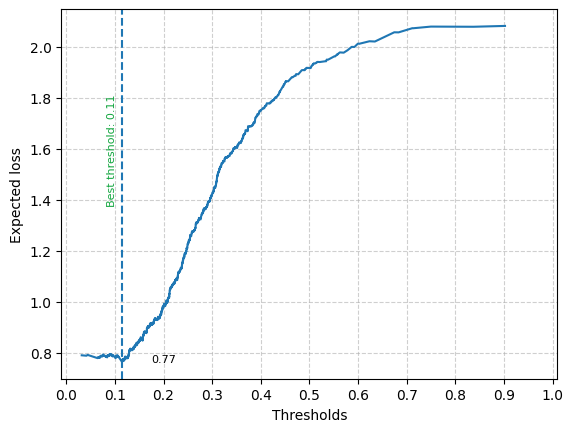

In [42]:
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)

This cell generates a ROC curve for the Random Forest model and highlights the point on the curve that corresponds to the optimal threshold.

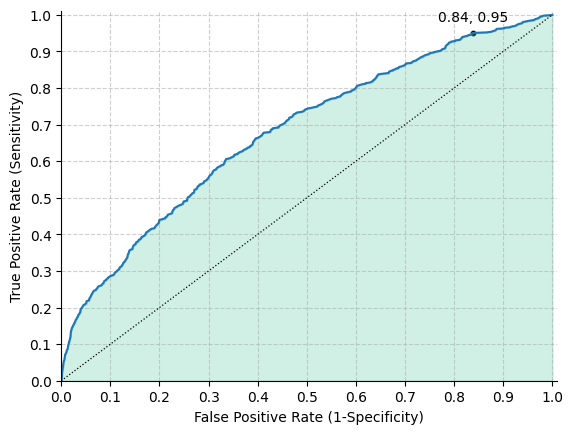

In [43]:
create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)

This cell calculates the RMSE of the Random Forest model on the holdout set.

In [44]:
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[
    :, 1
]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)


0.395

This cell calculates the AUC of the Random Forest model on the holdout set.

In [45]:
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)

0.664

This cell calculates the expected loss of the Random Forest model on the holdout set using the optimal threshold.

In [46]:
holdout_treshold = np.where(
    rf_predicted_probabilities_holdout < best_thresholds_cv["RF"], 0, 1
)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0, 1]).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(y_holdout)
round(expected_loss_holdout, 3)

0.772

This cell is a markdown header for the 'Final' section.

In [49]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Use the optimal threshold from CV
threshold = best_thresholds_cv["RF"]

# Convert probabilities to class predictions
y_pred_holdout = np.where(rf_predicted_probabilities_holdout < threshold, 0, 1)

# Compute confusion matrix
cm = confusion_matrix(y_holdout, y_pred_holdout, labels=[0, 1])

# Put into a nice table
cm_df = pd.DataFrame(
    cm,
    index=["Actual no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"]
)

cm_df

,Predicted no fast growth,Predicted fast growth
Actual no fast growth,347,2651
Actual fast growth,29,781


## Final

This cell adds the optimal threshold and expected loss to the main summary table for all models.

In [47]:
summary["CV treshold"] = best_thresholds_cv
summary["CV expected Loss"] = expected_loss_cv
summary

,Number of Coefficients,CV RMSE,CV AUC,CV treshold,CV expected Loss
M1,12.0,0.402774,0.595750,0.123274,0.783754
M2,19.0,0.397896,0.636457,0.080884,0.782309
M3,36.0,0.395653,0.652277,0.084045,0.782047
M4,80.0,0.393914,0.660418,0.085527,0.779814
M5,154.0,0.393951,0.663691,0.076899,0.770753
LASSO,112.0,0.393767,0.662557,0.088896,0.773708
RF,n.a.,0.391088,0.672707,0.099906,0.758735


This cell is a markdown header for 'Task 2', which involves running the model separately for Manufacturing and Services industries and comparing their performance using the same loss function.

## 9. Task 2: run the model separately for Manufacturing vs Services

- **Manufacturing:** NACE 10–33  
- **Services:** NACE 55–56, 95–96  

We keep the same loss function parameters (FP=1, FN=10) and compare performance.


This cell filters the data to create two separate DataFrames for the Manufacturing and Services industries. It then trains a Random Forest model for each industry group, calculates the AUC, optimal threshold, and expected loss, and finally prints a summary table comparing the results.

In [48]:
# Group 1: Manufacturing (NACE 10-33)
df_manuf = data[data['ind2_cat'].between(10, 33)]

# Group 2: Services (Accommodation, Food, Repair)
df_serv = data[data['ind2_cat'].isin([55, 56, 95, 96])]

print(f"Manufacturing Sample Size: {len(df_manuf)}")
print(f"Services Sample Size: {len(df_serv)}")

# 1. SETUP: Define groups and parameters
groups = {
    "Manufacturing": data[data['ind2_cat'].between(10, 33)],
    "Services": data[data['ind2_cat'].isin([55, 56, 95, 96])]
}

# Use your notebook's specific settings
FP = 1
FN = 10
cost = FN/FP

# 2. THE LOOP: Process each group exactly like your notebook
industry_results = []

# 1. Identify the features that are NOT industry-specific or location-specific strings
# We want the original column names from your dataframe
raw_features = [col for col in data.columns if col in rfvars_train.columns and "ind2_cat" not in col and "region_loc" not in col and "urban_m" not in col]

# Add back the basic versions of those categorical variables if they exist
# Or just use the list of numeric/binary columns you know are safe
safe_features = ['sales_mil_log', 'age', 'foreign_management', 'ceo_age', 'curr_liab_bs', 'profit_loss_year'] 

# 2. Update the Loop
for name, df_group in groups.items():
    print(f"Processing {name}...")
    
    # FIX: Use safe_features instead of rfvars.columns
    X_ind = df_group[safe_features] 
    y_ind = df_group['fast_growth']
    
    # Split Train/Holdout
    X_train_ind, X_holdout_ind, y_train_ind, y_holdout_ind = train_test_split(
        X_ind, y_ind, test_size=0.2, random_state=20240205)
    
    # Calculate prevalence for this specific group
    prev = y_train_ind.sum() / len(y_train_ind)
    
    # Run the Probability Forest (using your best parameters found earlier)
    # best_max_features and best_min_sample_split from your previous output
    rf_industry = RandomForestClassifier(
        n_estimators=500, 
        max_features=best_mtry, 
        min_samples_split=best_min_node_size,
        random_state=42)
    
    rf_industry.fit(X_train_ind, y_train_ind)
    
    # Get Holdout Predictions
    probs_holdout = rf_industry.predict_proba(X_holdout_ind)[:, 1]
    
    # Calculate AUC
    auc_score = roc_auc_score(y_holdout_ind, probs_holdout)
    
    # Calculate Optimal Threshold based on YOUR notebook's loss formula
    fpr, tpr, thresholds = roc_curve(y_holdout_ind, probs_holdout)
    optimal_t = sorted(list(zip(
        np.abs(tpr + (1 - prev)/(cost * prev)*(1-fpr)), thresholds)), 
        key=lambda i: i[0], reverse=True)[0][1]
    
    # Calculate Expected Loss on Holdout
    holdout_pred = np.where(probs_holdout < optimal_t, 0, 1)
    tn, fp, fn, tp = confusion_matrix(y_holdout_ind, holdout_pred, labels=[0,1]).ravel()
    exp_loss = (fp*FP + fn*FN) / len(y_holdout_ind)
    
    industry_results.append({
        'Industry': name,
        'N': len(df_group),
        'AUC': round(auc_score, 3),
        'Optimal Threshold': round(optimal_t, 3),
        'Expected Loss': round(exp_loss, 3)
    })

# 3. FINAL COMPARISON TABLE
task2_summary = pd.DataFrame(industry_results)
print(task2_summary)


Manufacturing Sample Size: 5562
Services Sample Size: 13474
Processing Manufacturing...
Processing Services...
        Industry      N    AUC  Optimal Threshold  Expected Loss
0  Manufacturing   5562  0.554              0.021          0.754
1       Services  13474  0.637              0.067          0.783
